In [1]:
# Download folder IndoNLU agar code bisa dijalankan
!git clone https://github.com/IndoNLP/indonlu.git -q

In [2]:
# konfigurasi skenario pengujian
rasio = 0.9
hgmodel = 'indolem/indobert-base-uncased'
batch_size = 16
num_workers = 4
lr = 1e-5
n_epochs = 5

In [3]:
import os, sys
sys.path.append('../')
os.chdir('../')
sys.path.append('/kaggle/working/indonlu') # memasukkan folder indoNLU ke environment

import random
import numpy as np
import pandas as pd
import torch
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from nltk.tokenize import TweetTokenizer

from utils.forward_fn import forward_sequence_classification
from utils.metrics import document_sentiment_metrics_fn
from utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

# Set random seed
set_seed(26092020)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained(hgmodel)
config = BertConfig.from_pretrained(hgmodel)
config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained(hgmodel, config=config)

count_param(model)

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


110560515

In [5]:
# Load auto-SentiSUM dataset
data = pd.read_excel('/kaggle/input/indonesia-summary-sentiment/Auto-SentiSUM.xlsx')
data

,category,news_text,manual_summary,Sentimen,auto_summary
0,tajuk utama,"Jakarta , CNN Indonesia - - Dokter Ryan Thamri...",Dokter Lula Kamal yang merupakan selebriti sek...,neutral,"ryan thamrin, dokter yang terkenal lewat acara..."
1,teknologi,Selfie ialah salah satu tema terpanas di kalan...,Asus memperkenalkan ZenFone generasi keempat...,positive,"meski telah tersedia banyak pilihan, asus zenf..."
2,hiburan,"Jakarta , CNN Indonesia - - Dinas Pariwisata P...",Dinas Pariwisata Provinsi Bengkulu kembali men...,positive,"jakarta, cnn indonesia - dinas pariwisata prov..."
3,tajuk utama,Merdeka.com - Indonesia Corruption Watch ( ICW...,Indonesia Corruption Watch ( ICW ) meminta Kom...,neutral,"peneliti icw, aradila caesar mengatakan moment..."
4,tajuk utama,Merdeka.com - Presiden Joko Widodo ( Jokowi ) ...,Jokowi memimpin upacara penurunan bendera . Us...,positive,usai prosesi penurunan bendera di halaman ista...
...,...,...,...,...,...
995,olahraga,"Rimanews - Yaya Toure dan agennya , Dimitri Se...","Yaya Toure dan agennya , Dimitri Seluk , berja...",positive,"yaya toure dan agennya, dimitri seluk, berjanj..."
996,tajuk utama,"Jakarta , CNN Indonesia - - Aksi kejahatan sib...",Aksi kejahatan siber baru-baru ini menemukan a...,neutral,"jakarta, cnn indonesia - aksi kejahatan siber ..."
997,olahraga,AC Milan tampak tidak ingin menghentikan gelia...,AC Milan tampak tidak ingin menghentikan gelia...,positive,ac milan tampak tidak ingin menghentikan gelia...
998,hiburan,"Jakarta , CNN Indonesia - - Di Indonesia , kun...",Kunyit ternyata dapat memutihkan gigi dengan c...,neutral,manfaat kunyit ternyata dapat mengurangi rasa ...


In [6]:
# Membuat manual summary dataset
df = data[['manual_summary', 'Sentimen']].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   manual_summary  1000 non-null   object
 1   Sentimen        1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


In [7]:
df['Sentimen'].value_counts()

Sentimen
positive    392
neutral     388
negative    220
Name: count, dtype: int64

In [8]:
# Membagi manual summary dataset menjadi train, val dan test data
train_data, temp_data = train_test_split(df, test_size=(1-rasio), random_state=42, stratify=df['Sentimen'])
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['Sentimen'])

print('Pembagian Dataset untuk pengujian:\nTraining Data\t: %s\nValidation Data\t: %s\nTesting Data\t: %s' %(train_data.shape, val_data.shape, test_data.shape))

train_data.to_csv('/kaggle/working/train_data.tsv', sep='\t', index=False, header=False)
val_data.to_csv('/kaggle/working/val_data.tsv', sep='\t', index=False, header=False)
test_data.to_csv('/kaggle/working/test_data.tsv', sep='\t', index=False, header=False)

Pembagian Dataset untuk pengujian:
Training Data	: (900, 2)
Validation Data	: (50, 2)
Testing Data	: (50, 2)


In [9]:
print('Komposisi Training Data')
print(train_data['Sentimen'].value_counts())

Komposisi Training Data
Sentimen
positive    353
neutral     349
negative    198
Name: count, dtype: int64


In [10]:
print('Komposisi Validasi Data')
print(val_data['Sentimen'].value_counts())

Komposisi Validasi Data
Sentimen
positive    20
neutral     19
negative    11
Name: count, dtype: int64


In [11]:
print('Komposisi Testing Data')
print(test_data['Sentimen'].value_counts())

Komposisi Testing Data
Sentimen
neutral     20
positive    19
negative    11
Name: count, dtype: int64


In [12]:
# Membuat auto summary dataset
df = data[['auto_summary', 'Sentimen']].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   auto_summary  1000 non-null   object
 1   Sentimen      1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


In [13]:
# Membagi auto summary dataset menjadi train, val dan test data
auto_train_data, temp_data = train_test_split(df, test_size=(1-rasio), random_state=42, stratify=df['Sentimen'])
auto_val_data, auto_test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['Sentimen'])

print('Ringkasan Otomatis Testing Data\t: ', test_data.shape)

# Hanya auto test data yang akan digunakan dalam pengujian
auto_test_data.to_csv('/kaggle/working/auto_test_data.tsv', sep='\t', index=False, header=False)

Ringkasan Otomatis Testing Data	:  (50, 2)


In [14]:
# menyiapkan dataset untuk training dan testing sesuai format BERT
train_dataset_path = '/kaggle/working/train_data.tsv'
valid_dataset_path = '/kaggle/working/val_data.tsv'
test_dataset_path = '/kaggle/working/test_data.tsv'

train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=batch_size, num_workers=num_workers, shuffle=False)

w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


In [15]:
optimizer = optim.Adam(model.parameters(), lr=lr)
model = model.cuda()

In [16]:
# Menjalankan Training dan Validasi
import time
start_time = time.time()

train_accuracy_list, train_f1_list, valid_accuracy_list, valid_f1_list = [], [], [], []
train_loss_list, valid_loss_list = [], []

# Train
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=False, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))
    
    train_loss_list.append(total_train_loss / (i+1))
    train_accuracy_list.append(metrics["ACC"])
    train_f1_list.append(metrics["F1"])

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)

    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=False, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),total_loss/(i+1), metrics_to_string(metrics)))
        
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))
    
    valid_loss_list.append(total_loss / (i+1))   
    valid_accuracy_list.append(metrics["ACC"])
    valid_f1_list.append(metrics["F1"])
    
#Hitung waktu total
end_time = time.time()
epoch_time = end_time - start_time
minutes = int(epoch_time // 60)
seconds = int(epoch_time % 60)
print(f"\nTraining time: {minutes}min {seconds}s")

# Calculate averages
avg_train_accuracy = sum(train_accuracy_list) / len(train_accuracy_list)
avg_train_f1 = sum(train_f1_list) / len(train_f1_list)
avg_valid_accuracy = sum(valid_accuracy_list) / len(valid_accuracy_list)
avg_valid_f1 = sum(valid_f1_list) / len(valid_f1_list)
# print(f"Avg. Training Accuracy: {avg_train_accuracy:.4f}")
print(f"Avg. Training F1 Score: {avg_train_f1:.4f}")
# print(f"Avg. Validation Accuracy: {avg_valid_accuracy:.4f}")
print(f"Avg. Validation F1 Score: {avg_valid_f1:.4f}")

(Epoch 1) TRAIN LOSS:1.0638 ACC:0.40 F1:0.32 REC:0.35 PRE:0.34 LR:0.00001000


(Epoch 1) VALID LOSS:0.9859 ACC:0.44 F1:0.37 REC:0.41 PRE:0.51


(Epoch 2) TRAIN LOSS:0.9280 ACC:0.56 F1:0.54 REC:0.53 PRE:0.58 LR:0.00001000


(Epoch 2) VALID LOSS:0.7240 ACC:0.68 F1:0.67 REC:0.67 PRE:0.68


(Epoch 3) TRAIN LOSS:0.7332 ACC:0.69 F1:0.70 REC:0.70 PRE:0.69 LR:0.00001000


(Epoch 3) VALID LOSS:0.6101 ACC:0.72 F1:0.73 REC:0.74 PRE:0.73


(Epoch 4) TRAIN LOSS:0.5624 ACC:0.78 F1:0.79 REC:0.79 PRE:0.78 LR:0.00001000


(Epoch 4) VALID LOSS:0.5207 ACC:0.72 F1:0.73 REC:0.75 PRE:0.74


(Epoch 5) TRAIN LOSS:0.4238 ACC:0.84 F1:0.84 REC:0.84 PRE:0.83 LR:0.00001000


(Epoch 5) VALID LOSS:0.5727 ACC:0.64 F1:0.65 REC:0.67 PRE:0.65

Training time: 0min 48s
Avg. Training F1 Score: 0.6360
Avg. Validation F1 Score: 0.6318


In [17]:
from sklearn.metrics import classification_report

# Evaluate on test human summary dataset
model.eval()
torch.set_grad_enabled(False)

list_data, list_hyp, list_label = [], [], []

pbar = tqdm(test_loader, leave=False, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    list_hyp += batch_hyp
    list_label += batch_label
    list_data += batch_data
metrics = document_sentiment_metrics_fn(list_hyp, list_label)
test_accuracy = metrics["ACC"]
test_f1 = metrics["F1"]

report = classification_report(list_label, list_hyp, target_names=['negative', 'neutral', 'positive'])
print(report)

print(f"Testing by Human F1 Score: {test_f1:.4f}")

              precision    recall  f1-score   support

    negative       0.57      0.73      0.64        11
     neutral       0.65      0.55      0.59        20
    positive       0.84      0.84      0.84        19

    accuracy                           0.70        50
   macro avg       0.69      0.71      0.69        50
weighted avg       0.70      0.70      0.70        50

Testing by Human F1 Score: 0.6922


In [20]:
auto_test_dataset_path = '/kaggle/working/auto_test_data.tsv'
auto_test_dataset = DocumentSentimentDataset(auto_test_dataset_path, tokenizer, lowercase=True)
auto_test_loader = DocumentSentimentDataLoader(dataset=auto_test_dataset, max_seq_len=512, batch_size=batch_size, num_workers=num_workers, shuffle=False)

# Evaluate on test
model.eval()
torch.set_grad_enabled(False)

list_hyp, list_label = [], []

pbar = tqdm(auto_test_loader, leave=False, total=len(auto_test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    list_hyp += batch_hyp
    list_label += batch_label
metrics = document_sentiment_metrics_fn(list_hyp, list_label)
test_accuracy = metrics["ACC"]
test_f1 = metrics["F1"]

report = classification_report(list_label, list_hyp, target_names=['negative', 'neutral', 'positive'])
print(report)

print(f"Testing by Comp F1 Score: {test_f1:.4f}")

              precision    recall  f1-score   support

    negative       0.41      0.64      0.50        11
     neutral       0.41      0.35      0.38        20
    positive       0.75      0.63      0.69        19

    accuracy                           0.52        50
   macro avg       0.52      0.54      0.52        50
weighted avg       0.54      0.52      0.52        50

Testing by Comp F1 Score: 0.5214


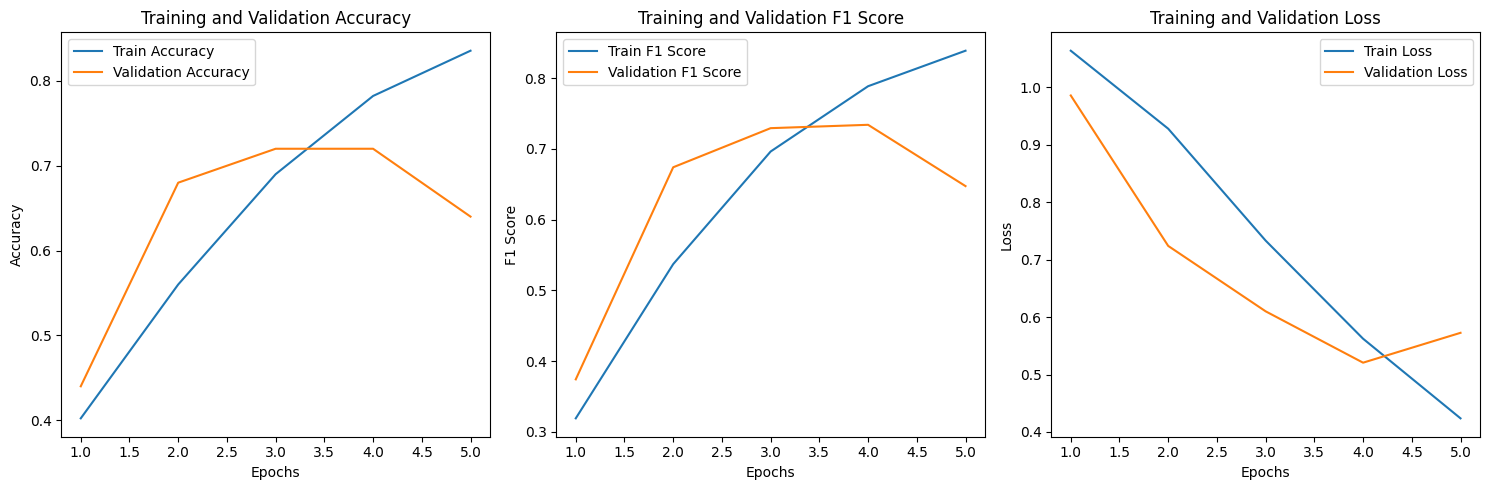

In [21]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, n_epochs+1), train_accuracy_list, label='Train Accuracy')
plt.plot(range(1, n_epochs+1), valid_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(1, n_epochs+1), train_f1_list, label='Train F1 Score')
plt.plot(range(1, n_epochs+1), valid_f1_list, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Score')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(1, n_epochs+1), train_loss_list, label='Train Loss')
plt.plot(range(1, n_epochs+1), valid_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
text = 'Bahagia hatiku melihat pernikahan putri sulungku yang cantik jelita'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Bahagia hatiku melihat pernikahan putri sulungku yang cantik jelita | Label : positive (59.723%)


In [ ]:
# data = pd.read_excel('/kaggle/working/TestLog.xlsx')

# # Tambahkan data ke dalam dataframe
# data = data._append({
#     "Pre-Trained": hgmodel,
#     "Batch Size": batch_size,
#     "Learning Rate": lr,
#     "Epoch": n_epochs,
#     "Avg Training Accuracy": avg_train_accuracy,
#     "Avg Validation Accuracy": avg_valid_accuracy,
#     "Test Accuracy": test_accuracy,
#     "Avg Training F1-Score": avg_train_f1,
#     "Avg Validation F1-Score": avg_valid_f1,
#     "Test F1-Score": test_f1,
#     "Training Time": epoch_time,
#     "Training Time (String)": f"{minutes}min {seconds}s",
#     "Rasio Dataset": rasio,
#     "Jumlah Dataset": len(df)
# }, ignore_index=True)

# data.to_excel('/kaggle/working/TestLog.xlsx', index=False)

# data

In [ ]:
# # Simpan model dan optimizer (opsional)
# save_path = f"{hgmodel}_{n_epochs}_{batch_size}.pth"
# torch.save({
#     'epoch': epoch,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'train_loss_list': train_loss_list,
#     'valid_loss_list': valid_loss_list,
#     'train_accuracy_list': train_accuracy_list,
#     'train_f1_list': train_f1_list,
#     'valid_accuracy_list': valid_accuracy_list,
#     'valid_f1_list': valid_f1_list
# }, save_path)